In [1]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append("../bda_models")
sys.path.append(CODE_DIR)

In [2]:
import os
import torch
import pandas as pd
import numpy as np

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import torch.distributions as td

from datasets import load_dataset, ReadInstruction

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
from analysis.bda_models.bda_topic_model_ptb import GenLDATopicModelPTB
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from gensim_LDA import LdaModel # I made local alterations
from gensim.models import CoherenceModel # from the gensim module

# Get some PTB data (train & valid)

In [3]:
MAX_DATA_SAMPLES = 10000

# PENN TREE BANK
ptb_train_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="train")
ptb_train_text_samples = ptb_train_dataset["sentence"][:MAX_DATA_SAMPLES]

ptb_valid_dataset = load_dataset("ptb_text_only", ignore_verifications=True, split="validation")
ptb_valid_text_samples = ptb_valid_dataset["sentence"][:MAX_DATA_SAMPLES]

print(f"Len train samples", len(ptb_train_text_samples))
# print(f"Example train sample:\n\n{ptb_train_text_samples[0]}", end="\n\n")

print(f"Len valid samples", len(ptb_valid_text_samples))
# print(f"Example valid sample:\n\n{ptb_valid_text_samples[0]}")

W0117 14:40:28.876728 23422264655616 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)
W0117 14:40:29.448445 23422264655616 builder.py:539] Reusing dataset ptb_text_only (/home/cbarkhof/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)


Len train samples 10000
Len valid samples 3370


# Generative LDA Model PTB

In [4]:
temp = GenLDATopicModelPTB(train_samples_strings=ptb_train_text_samples)

train_id2word = temp.dictionary
train_docs = temp.train_docs
train_corpus = temp.train_corpus

valid_corpus, valid_docs = temp.lda_preprocess_transform(text_samples=ptb_valid_text_samples)

I0117 14:40:33.090228 23422264655616 phrases.py:583] collecting all words and their counts
I0117 14:40:33.092046 23422264655616 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0117 14:40:33.329499 23422264655616 phrases.py:609] collected 82407 token types (unigram + bigrams) from a corpus of 121114 words and 10000 sentences
I0117 14:40:33.330968 23422264655616 phrases.py:666] merged Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
I0117 14:40:33.337871 23422264655616 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.25s', 'datetime': '2022-01-17T14:40:33.335902', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0117 14:40:33.763526 23422264655616 dictionary.py:199] adding document #0 to Dictionary(0 unique tokens

Number of unique tokens: 3743
Number of documents: 10000


I0117 14:42:00.555704 23422264655616 utils.py:447] LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=3743, num_topics=10, decay=0.5, chunksize=2000> in 85.62s', 'datetime': '2022-01-17T14:42:00.555596', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0117 14:42:00.923525 23422264655616 phrases.py:583] collecting all words and their counts
I0117 14:42:00.924934 23422264655616 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0117 14:42:01.009771 23422264655616 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I0117 14:42:01.011106 23422264655616 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0117 14:42:01.012220 23422264655616 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, m

In [5]:
# supporting function
def evaluate_setting(train_corpus, train_docs, train_id2word, valid_corpus, k, a, b):
    
    lda_model = LdaModel(corpus=train_corpus,
                         id2word=train_id2word,
                         num_topics=k, 
                         random_state=100,
                         chunksize=2000,
                         eval_every=5,
                         passes=20,
                         alpha=a,
                         eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=train_docs, 
                                         dictionary=train_id2word, 
                                         coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    log_ppl = lda_model.log_perplexity(valid_corpus, total_docs=len(train_corpus))
    
    return coherence_score, log_ppl

# Do a small grid search experiment

In [6]:
import tqdm

re_compute = False
save_file = "lda_tuning_results.pt"

if not re_compute:
    model_results = torch.load(save_file)
else:
    # Topics range
    min_topics = 4
    max_topics = 12
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)

    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('auto')
    alpha.append('asymmetric')

    # Beta parameter
    # beta = list(np.arange(0.01, 1, 0.3))
    # beta.append('symmetric')
    beta = ["auto"]

    # Can take a long time to run
    counter = 1
    total_exp = int(len(alpha) * len(beta) * len(topics_range))

    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:

                print("-"*80)
                print(f"Experiment {counter}/{total_exp}")
                print(f"K={k} alpha={a} beta={b}")

                coherence_score, log_ppl = evaluate_setting(train_corpus=train_corpus, 
                                 train_docs=train_docs, 
                                 train_id2word=train_id2word, 
                                 valid_corpus=valid_corpus, 
                                 k=k, 
                                 a=a, 
                                 b=b)

                print(f"Coherence score: {coherence_score:.2f}")
                print(f"Log perplexity: {log_ppl:.2f}")

                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence (CV)'].append(coherence_score)
                model_results['Log PPL'].append(log_ppl)

            torch.save(model_results, save_file)
            counter += 1

In [7]:
df = pd.DataFrame(model_results)
df.head()

,Topics,Alpha,Beta,Coherence (CV),Log PPL
0,4,0.01,auto,0.280293,-7.850369
1,4,0.31,auto,0.300442,-7.598280
2,4,0.61,auto,0.261433,-7.548129
3,4,0.91,auto,0.248110,-7.532720
4,4,auto,auto,0.314326,-7.543254


I0117 14:42:01.426190 23422264655616 utils.py:145] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0117 14:42:01.427673 23422264655616 utils.py:157] NumExpr defaulting to 8 threads.


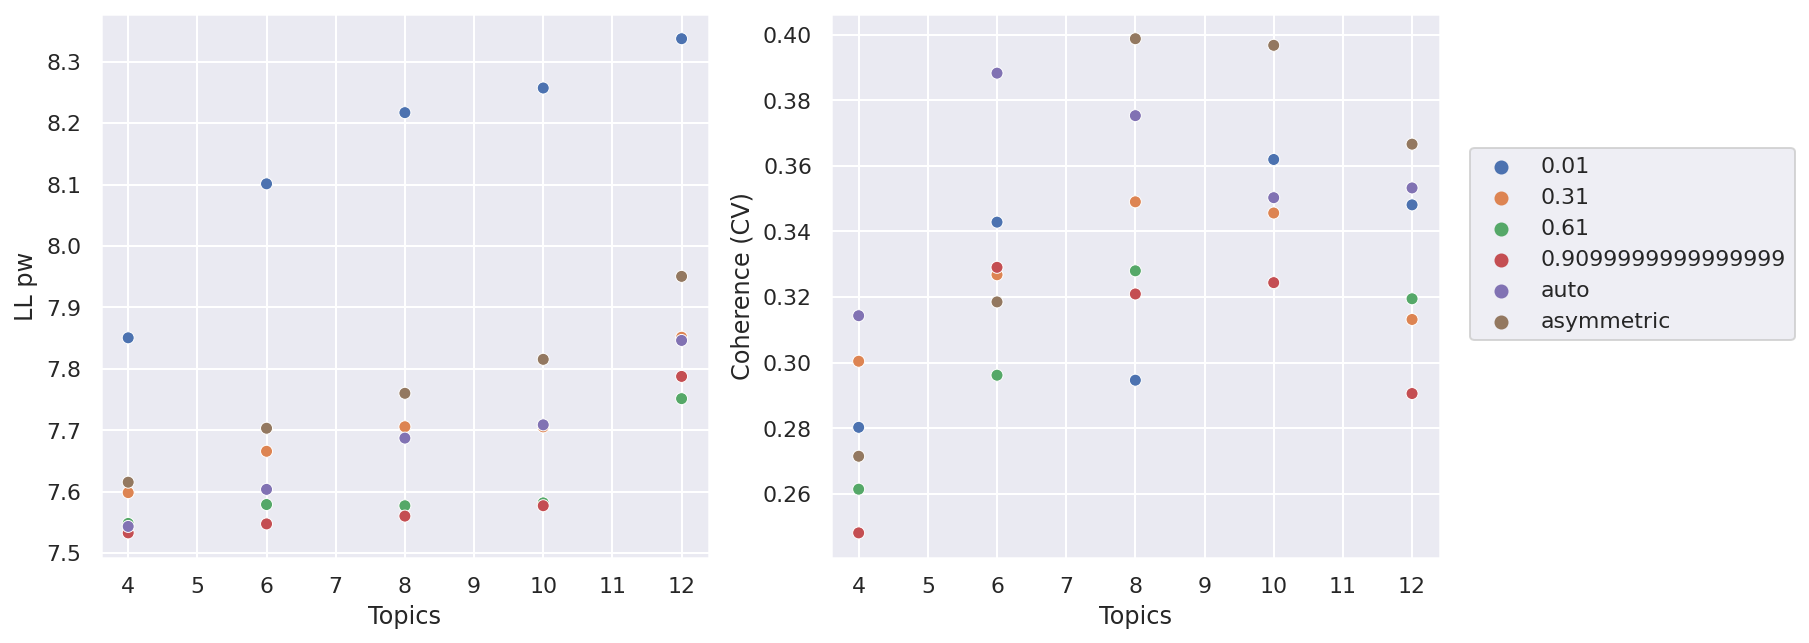

In [8]:
df["LL pw"] = - df["Log PPL"]

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.scatterplot(data=df, x="Topics", y="LL pw", hue="Alpha", ax=axs[0])
sns.scatterplot(data=df, x="Topics", y="Coherence (CV)", hue="Alpha", ax=axs[1])

axs[0].legend().remove()
axs[1].legend(loc=(1.05, 0.4))

# Train final model

In [9]:
# Read of grid search
ALPHA = 0.01
BETA = "auto"
N_TOPICS = 10

gen_model_lda = GenLDATopicModelPTB(
    train_samples_strings=ptb_train_text_samples, 
    alpha=ALPHA,
    beta=BETA,
    num_topics=N_TOPICS, 
    chunksize=2000, 
    passes=20, 
    iterations=600, 
    eval_every=None)

I0117 14:42:03.918578 23422264655616 phrases.py:583] collecting all words and their counts
I0117 14:42:03.920108 23422264655616 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0117 14:42:04.151732 23422264655616 phrases.py:609] collected 82407 token types (unigram + bigrams) from a corpus of 121114 words and 10000 sentences
I0117 14:42:04.153153 23422264655616 phrases.py:666] merged Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
I0117 14:42:04.154244 23422264655616 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<82407 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.24s', 'datetime': '2022-01-17T14:42:04.154200', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}
I0117 14:42:04.580675 23422264655616 dictionary.py:199] adding document #0 to Dictionary(0 unique tokens

Number of unique tokens: 3743
Number of documents: 10000


I0117 14:43:32.747743 23422264655616 utils.py:447] LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=3743, num_topics=10, decay=0.5, chunksize=2000> in 87.09s', 'datetime': '2022-01-17T14:43:32.747625', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


In [10]:
def resample_corpus(corpus, topic_model, n_samples=50, max_docs=None):
    """
    Resample corpus from posterior of a topic model.

    Parameters
    ----------
    corpus: List( List ( Tuple (int idx, float count)))
        a list of documents in the sparse document format:
    topic_model: LdaModel
        a Gensim LDA topic model
    n_samples: int
        number of times to resample a doc
    max_docs: int, None
        max number of documents to resample, if None resample all
        
    Returns
    ----------
    word_dists_orig: np.array [n_docs, n_vocab]
        original word counts in matrix form
    word_dists_resample: np.array [n_docs, n_samples, n_vocab]
        resampled word counts in matrix form
    """
    max_docs = len(corpus) if max_docs is None else max_docs
    
    # N_topics, N_words
    topic_word_matrix = topic_model.get_topics()
    n_topics, n_vocab = topic_word_matrix.shape
    
    word_dists_orig = []
    word_dists_resample = []
    
    for d_i, bow in enumerate(corpus):
        # Infer document topic distribution
        # list of tuples (topic_id, probability)
        topic_dist = topic_model.get_document_topics(bow=bow)
        topic_dist_flat = np.zeros(n_topics)
        for (t_idx, t_p) in topic_dist:
            topic_dist_flat[t_idx] = t_p
        topic_dist_flat /= topic_dist_flat.sum()

        # Make vocab size vector with word counts
        d_orig = np.zeros(n_vocab)
        for i, c in bow:
            d_orig[i] = c
        n_words = int(np.sum(d_orig))

        d_resample = []
        for n in range(n_samples):
            print(f"Doc {d_i:3d}/{max_docs:3d} Sample {n:3d}/{n_samples:3d}", end="\r")

            # Re-sample the doc
            sample = np.zeros(n_vocab)
            for _ in range(n_words):
                # Sample topic
                topic = np.random.choice(n_topics, 1, p=topic_dist_flat)[0]

                # Get topic-word distribution
                word_dist = topic_word_matrix[topic]
                n_vocab = len(word_dist)

                word_id = np.random.choice(n_vocab, 1, p=word_dist)[0]
                sample[word_id] += 1.

            d_resample.append(sample)
        # stack samples for doc
        d_resample = np.stack(d_resample)

        word_dists_orig.append(d_orig)
        word_dists_resample.append(d_resample)

        if d_i + 1 == max_docs: break

    word_dists_orig = np.stack(word_dists_orig)
    word_dists_resample = np.stack(word_dists_resample)

    print(word_dists_orig.shape)
    print(word_dists_resample.shape)
    
    return word_dists_orig, word_dists_resample

def plot_word_dists(word_dists_orig, word_dists_resample):
    fig, ax = plt.subplots(figsize=(12, 4))
    
    true_word_dist = word_dists_orig.mean(axis=0)
    idx_order = np.argsort(true_word_dist)[::-1]
    true_word_dist_ordered = true_word_dist[idx_order]
    
    # [n_docs, n_samples, n_vocab] -> [n_samples, n_vocab]
    word_dists = np.transpose(np.mean(word_dists_resample, axis=0))
    n_vocab, n_samples = word_dists.shape
    
    print(n_vocab, n_samples)
    word_dists = word_dists[idx_order]
    print(word_dists.shape)

    indices = np.arange(n_vocab)[:, None]
    indices = np.tile(indices, (1, n_samples))
    
    ax.scatter(indices.flatten(), word_dists.flatten(), alpha=0.1, s=1, 
               label="sampled freqs. (blue)")
    ax.scatter(np.arange(n_vocab), true_word_dist_ordered, color='black', alpha=1.0, 
               label="obs freqs. (black)", s=1, marker="_")
    ax.set_xlabel("Vocab idx")
    ax.set_ylabel("Frequency")
    
    leg = ax.legend(loc=(1.02, 0.8))
    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    
    plt.show()

In [15]:
n_samples = 50
topic_model = gen_model_lda.lda_model
valid_corpus, _ = gen_model_lda.lda_preprocess_transform(text_samples=ptb_valid_text_samples)
word_dists_orig, word_dists_resample = resample_corpus(valid_corpus, topic_model, 
                                                       n_samples=n_samples, max_docs=None)

I0117 12:45:54.415190 23158464888576 phrases.py:583] collecting all words and their counts
I0117 12:45:54.416898 23158464888576 phrases.py:588] PROGRESS: at sentence #0, processed 0 words and 0 word types
I0117 12:45:54.450743 23158464888576 phrases.py:609] collected 32676 token types (unigram + bigrams) from a corpus of 39852 words and 3370 sentences
I0117 12:45:54.452155 23158464888576 phrases.py:666] merged Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
I0117 12:45:54.453537 23158464888576 utils.py:447] Phrases lifecycle event {'msg': 'built Phrases<32676 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.04s', 'datetime': '2022-01-17T12:45:54.453513', 'gensim': '4.1.2', 'python': '3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]', 'platform': 'Linux-4.19.0-18-amd64-x86_64-with-debian-10.11', 'event': 'created'}


(3370, 3743)0 Sample  49/ 50
(3370, 50, 3743)


3743 50
(3743, 50)


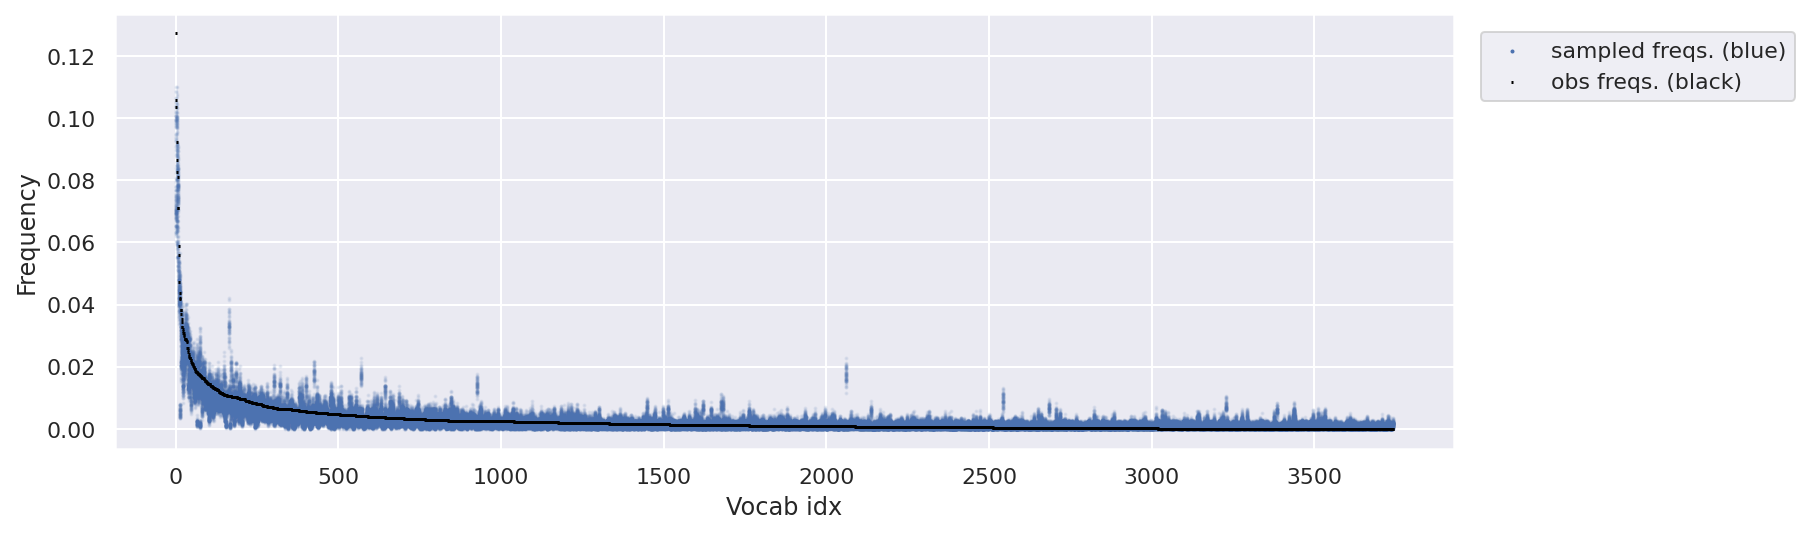

In [16]:
plot_word_dists(word_dists_orig, word_dists_resample)

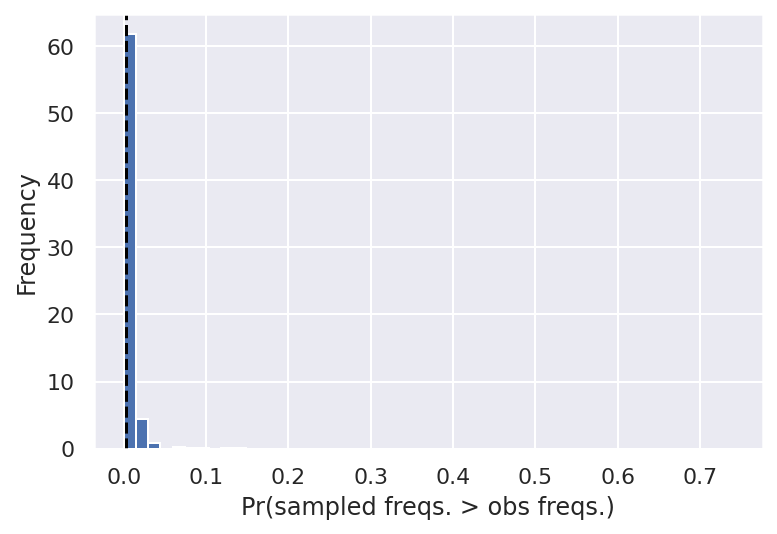

In [17]:
word_dists_orig.shape, word_dists_resample.shape

pvals = (word_dists_resample > word_dists_orig[:, None, :]).mean(axis=1)
pvals = pvals.flatten()

plt.hist(pvals, bins=50, density=True)
plt.axvline(pvals.mean(), linestyle="--", color="black")
_ = plt.xlabel(f'Pr(sampled freqs. > obs freqs.)')
_ = plt.ylabel("Frequency")

In [11]:
# gen_topic_model = gen_model_lda
# gen_topic_model.print_topics()

from tabulate import tabulate

topics = gen_model_lda.lda_model.show_topics()

table = []
headers = ["Topic"] + [f"{i}" for i in range(10)]

for t_idx in range(N_TOPICS):
    top_terms = gen_model_lda.lda_model.get_topic_terms(t_idx, topn=10)
    out = [train_id2word[idx] for (idx, _) in top_terms]
    out = [t_idx] + out
    table.append(out)
    
print(tabulate(table, headers=headers))

  Topic  0          1        2         3         4                5        6         7          8        9
-------  ---------  -------  --------  --------  ---------------  -------  --------  ---------  -------  --------
      0  program    trading  big       mr        program_trading  board    pacific   market     one      georgia
      1  mr         would    company   court     federal          say      could     law        even     plan
      2  corp       company  year      inc       co               bank     million   last       week     computer
      3  mr         say      state     gene      judge            cancer   one       may        made     would
      4  president  mr       would     soviet    say              vice     bush      american   house    leader
      5  rate       say      long      interest  term             market   security  street     manager  issue
      6  stock      market   company   chief     index            price    new       executive  buy      fut

# Gather models to evaluate under the fit generative model

In [12]:
overview_df = make_run_overview_df(prefixes=["(5-jan ptb-test)", "(4-jan ptb-test)", "(10-jan ptb)", "(11-jan ptb)"])
overview_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 2 l_MMD 1000 dec: Weak-M roBERTa,INFO-VAE,2,ptb,language,0,0,0,1000,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 100 dec: Weak-M roBERTa,INFO-VAE,2,ptb,language,0,0,0,100,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 10 dec: Weak-M roBERTa,INFO-VAE,2,ptb,language,0,0,0,10,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 1 dec: Weak-M roBERTa,INFO-VAE,2,ptb,language,0,0,0,1,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=1...."
INFO-VAE l_Rate 1 l_MMD 100 dec: Weak-M roBERTa,INFO-VAE,1,ptb,language,0,0,0,100,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=10..."


In [13]:
MAX_MODEL_SAMPLES = 200

EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

ptb_model_text_samples = dict()

for i, (clean_name, row) in enumerate(overview_df.iterrows()):
    print(i, clean_name)
    
    save_dir = f"{EXPORT_DIR}/{row.run_name}"
    conditional_samples_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
    samples_file = f"{save_dir}/{SAMPLE_FILE}"
    
    cond_samples = torch.load(conditional_samples_file)["valid"]
    samples = torch.load(samples_file)
    
    d = {
        "conditional_original_text": cond_samples["original_input_text"][:MAX_MODEL_SAMPLES],
        "conditional_sampled_text": cond_samples["condtional_sample_text"][:MAX_MODEL_SAMPLES],
        "unconditional_sampled_text": samples["text"][:MAX_MODEL_SAMPLES]
    }
    
    ptb_model_text_samples[clean_name] = d
    
    for k, v in ptb_model_text_samples[clean_name].items():
        print(k, len(v))
    
    print()
    
ptb_model_text_samples["data_group"] = {
    "conditional_original_text": ptb_valid_text_samples,
    "conditional_sampled_text": ptb_valid_text_samples,
    "unconditional_sampled_text": ptb_valid_text_samples
}

0 INFO-VAE l_Rate 2 l_MMD 1000 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

1 INFO-VAE l_Rate 2 l_MMD 100 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

2 INFO-VAE l_Rate 2 l_MMD 10 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

3 INFO-VAE l_Rate 2 l_MMD 1 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

4 INFO-VAE l_Rate 1 l_MMD 100 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

5 INFO-VAE l_Rate 0.5 l_MMD 100 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

6 INFO-VAE l_Rate 0.5 l_MMD 1000 dec: Weak-M roBERTa
conditional_original_text 200
conditional_sampled_text 200
unconditional_sampled_text 200

7 INFO-VAE

# Assess surprisal of model samples under generative model

In [14]:
re_compute = False
save_file = "topic_model_surprisal_values.pt"

gen_topic_model = gen_model_lda
if re_compute:

    N_PERM = 50

    surprisal_values = dict()

    for idx, (clean_name, text_samples) in enumerate(ptb_model_text_samples.items()):
        print(f"{idx:2d}/{len(ptb_model_text_samples.keys())}")

        surprisal_values[clean_name] = gen_topic_model.assess_surprisal_under_model(text_samples, N_perm=N_PERM)

    torch.save(surprisal_values, save_file)
else:

    surprisal_values = torch.load(save_file)


# Plot surprisal distribution and add global statistics

In [15]:
global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) & (global_stats_df.phase == "valid")]
global_stats_df.head()

,phase,IW LL,MMD,PPL,distortion,elbo,kl_prior_post,mean_mean,mean_scale,std_across_x_mean,...,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 2 l_MMD 1000 dec: Weak-M roBERTa,valid,-157.229849,1.192093e-07,0.002457,158.061217,-159.172941,1.111723,0.000278,0.978075,0.037297,...,INFO-VAE,2.0,ptb,language,0.0,0,0,1000,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 100 dec: Weak-M roBERTa,valid,-157.814097,2.026558e-06,0.002760,155.953692,-157.933609,1.979917,0.003768,0.961793,0.071776,...,INFO-VAE,2.0,ptb,language,0.0,0,0,100,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 10 dec: Weak-M roBERTa,valid,-157.884664,1.811981e-05,0.002812,154.611532,-156.663994,2.052462,0.002243,0.962558,0.077313,...,INFO-VAE,2.0,ptb,language,0.0,0,0,10,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=10..."
INFO-VAE l_Rate 2 l_MMD 1 dec: Weak-M roBERTa,valid,-155.159271,2.944469e-05,0.002762,154.306195,-156.424200,2.118004,-0.005595,0.961617,0.078039,...,INFO-VAE,2.0,ptb,language,0.0,0,0,1,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=2.0, l_2_mmd=1...."
INFO-VAE l_Rate 1 l_MMD 100 dec: Weak-M roBERTa,valid,-151.793966,7.891655e-05,0.003379,147.790939,-153.177282,5.386344,0.010199,0.916638,0.148914,...,INFO-VAE,1.0,ptb,language,0.0,0,0,100,weak_memory_distil_roberta_decoder,"(11-jan ptb) INFO-VAE[l_1_rate=1.0, l_2_mmd=10..."


Rows: 15, cols: 3, every: 3, n_groups: 52


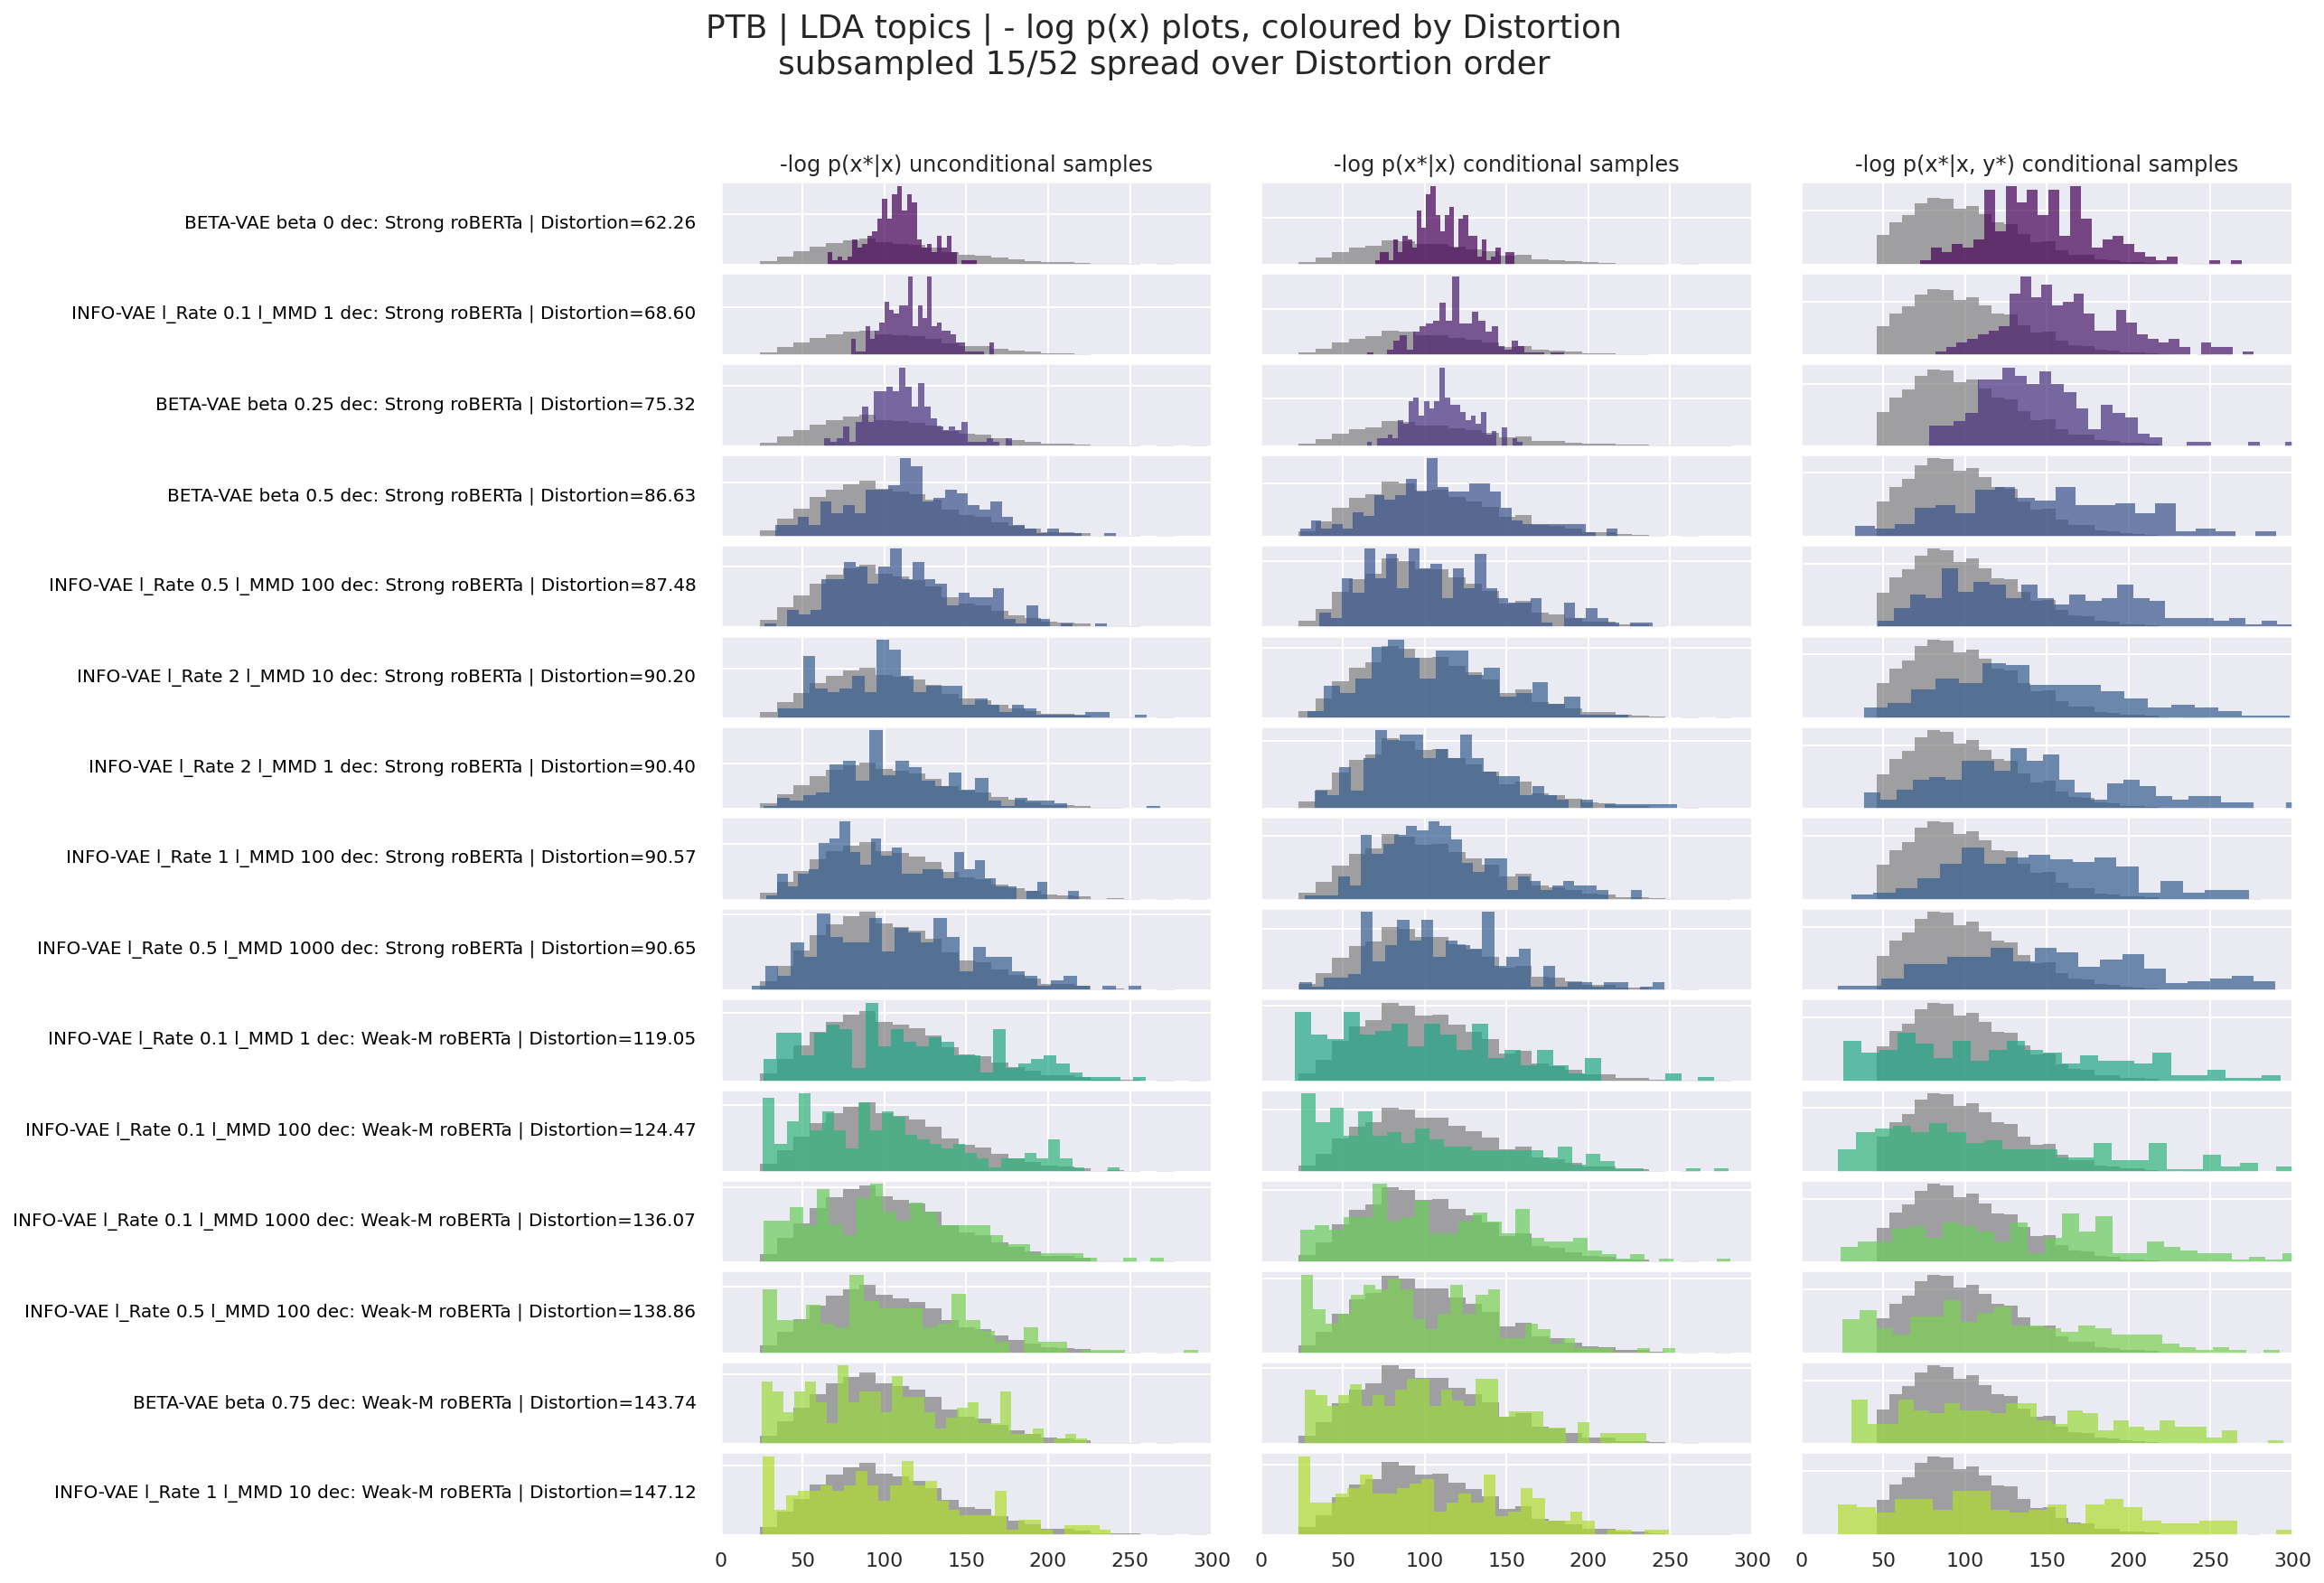

In [16]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

# Filter our really high rate runs
# global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="distortion", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Distortion", 
                                         bins=30,
                                         title_size=18,
                                         title_y=1.08,
                                         subsample_nrows=15, 
                                         sort_ascend=True, 
                                         row_height=0.75)

Rows: 15, cols: 3, every: 3, n_groups: 50


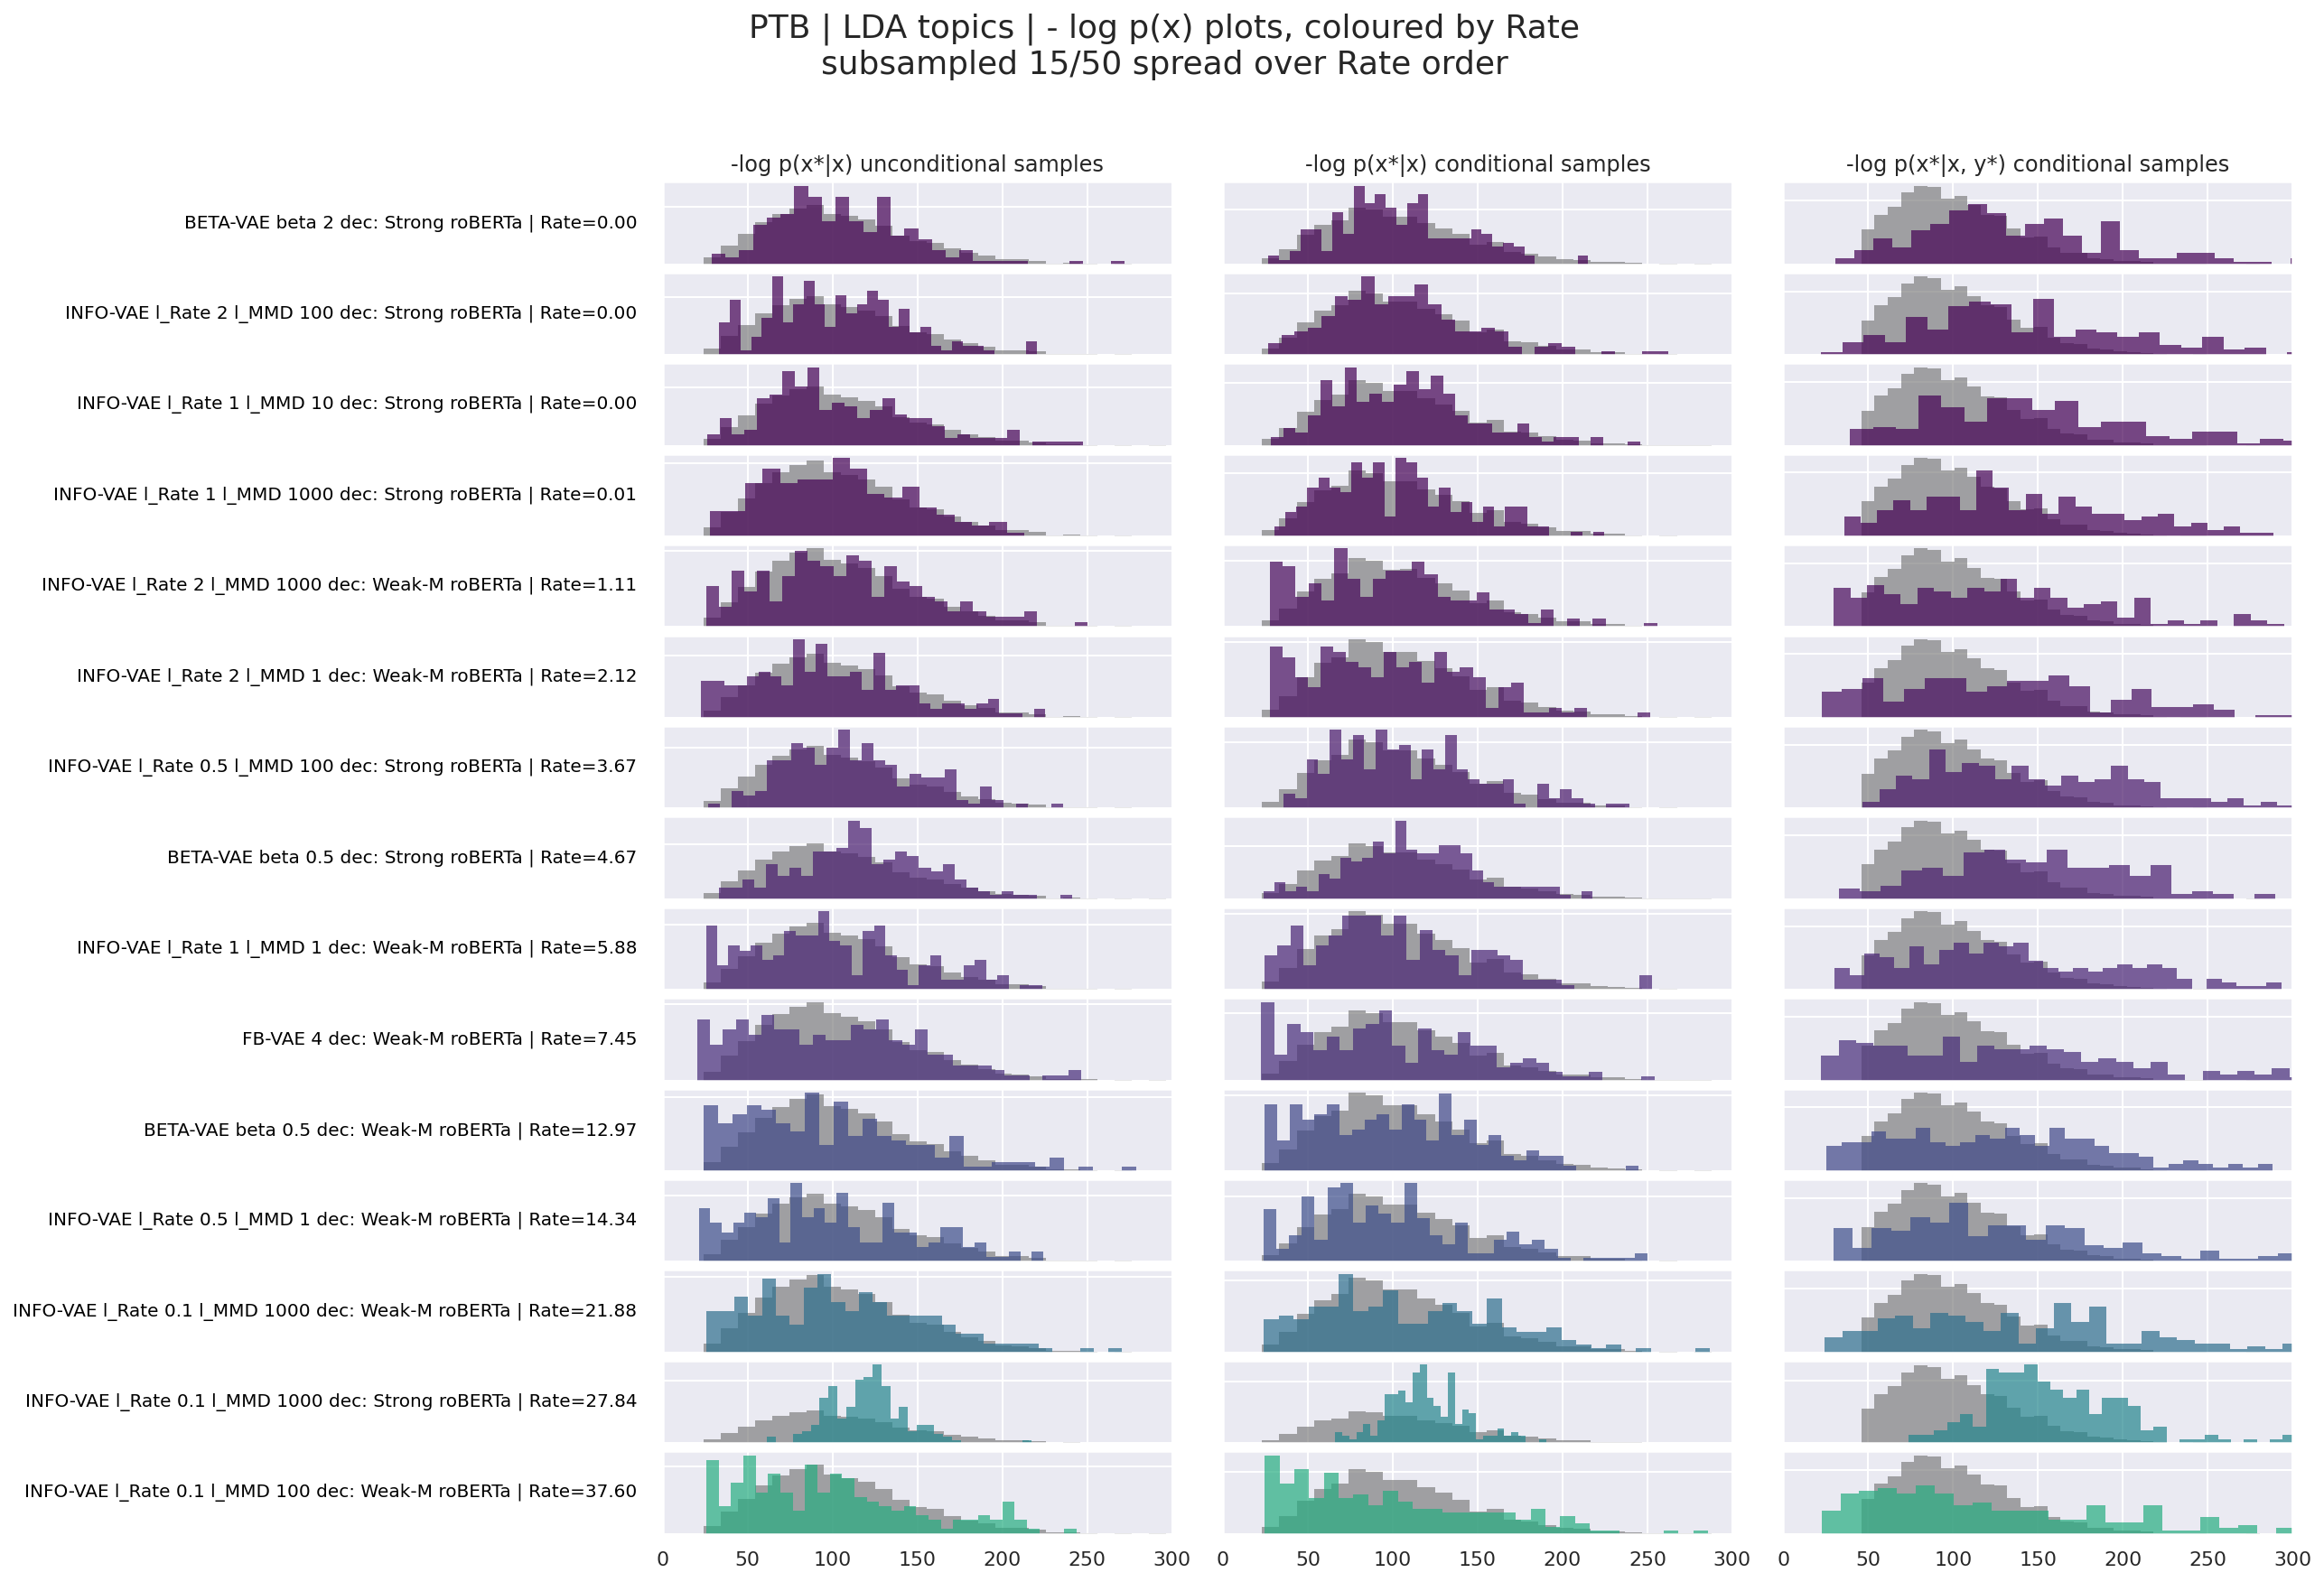

In [17]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df.kl_prior_post < 150]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Rate", 
                                         bins=30,
                                         title_size=18,
                                         title_y=1.08,
                                         subsample_nrows=15, 
                                         sort_ascend=True, 
                                         row_height=0.75)

Rows: 15, cols: 3, every: 3, n_groups: 50


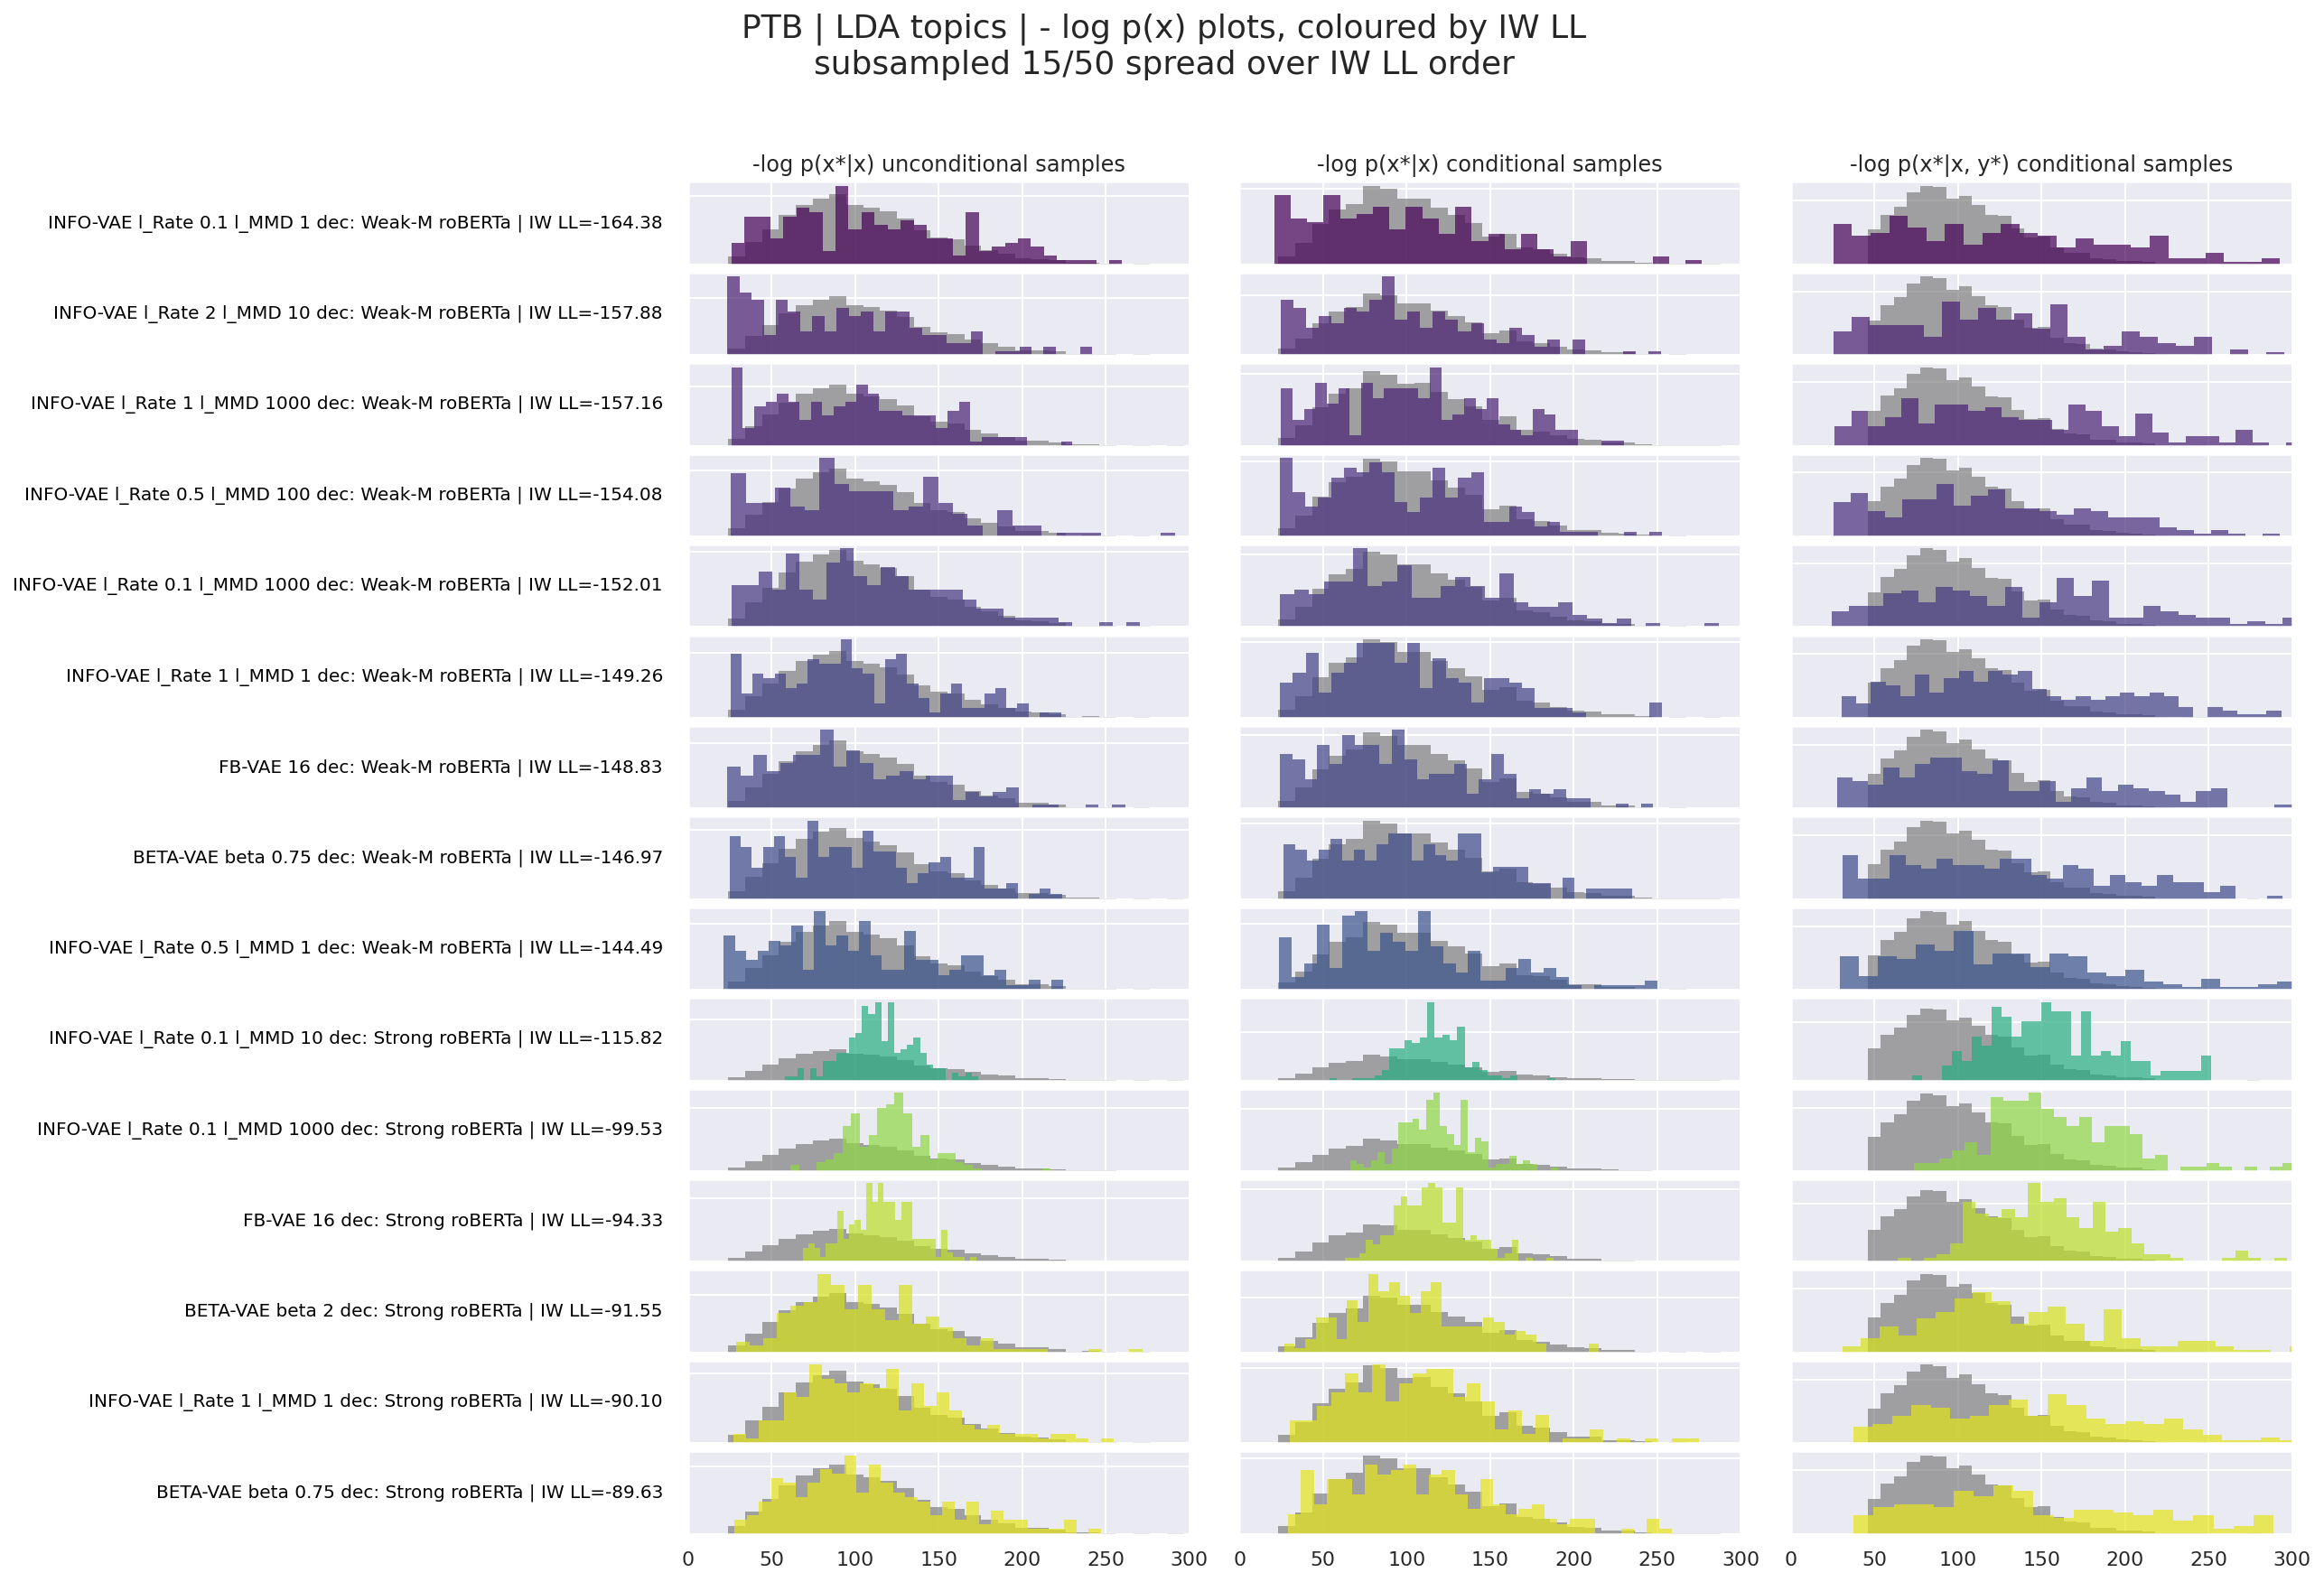

In [18]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[global_stats_df["IW LL"] > -170]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="IW LL", 
                                         bins=30,
                                         title_size=18,
                                         title_y=1.08,
                                         subsample_nrows=15, 
                                         sort_ascend=True, 
                                         row_height=0.75)

# Analyse surprisal distribution with a DP mixture of truncated normals

In [23]:
save_file = "PTB_lda_topic_surprisal_dp_mixtures.p"
perform_prior_predictive_checks = False
re_compute = True

MAX_SAMPLES_PER_GROUP = 200

NUM_COMPS = 8
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1000

if re_compute:
    dp_mixtures = dict()
    # dp_mixtures = pickle.load(open(save_file, "rb"))
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)

        group_names = []
        observations = []

        for k, v in surprisal_values.items():
            group_names.append(k)
            observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist="normal", 
#             truncated_normal_low=19.0,
            DP_alpha=1., 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )

        dp_mixture.run()

        dp_mixtures[stat_name] = dp_mixture
    
        pickle.dump(dp_mixtures, open(save_file, "wb"))
    
else:
    dp_mixtures = pickle.load(open(save_file, "rb"))

unconditional_unconditional


sample:  10%|█         | 113/1100 [08:32<1:14:36,  4.54s/it, 1023 steps of size 1.21e-05. acc. prob=0.80]


KeyboardInterrupt: 

# Plot the DP Mixture fits on surprisal values

In [ ]:
# from scipy import stats

# mins = []
# maxs = []
# names = []

# for group, d in surprisal_values.items():
#     print("-"*40)
#     print(group)
#     for k, v in d.items():
#         if min(v) < 19.0: print("WARNING")
#         print(k, min(v), max(v))
        

In [ ]:
for stat, dp_mixture in dp_mixtures.items():
    print(stat.upper())

    plot_model_data_preds_obs(dp_mixture)
    samples = dp_mixture.draw_posterior_predictions()["y"]
    surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=2)
    # plot_all_groups_preds_obs(dp_mixture)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [31]:
all_df = compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values, num_components=NUM_COMPS)

UNCONDITIONAL_UNCONDITIONAL
UNCONDITIONAL_CONDITIONAL
CONDITIONAL_CONDITIONAL


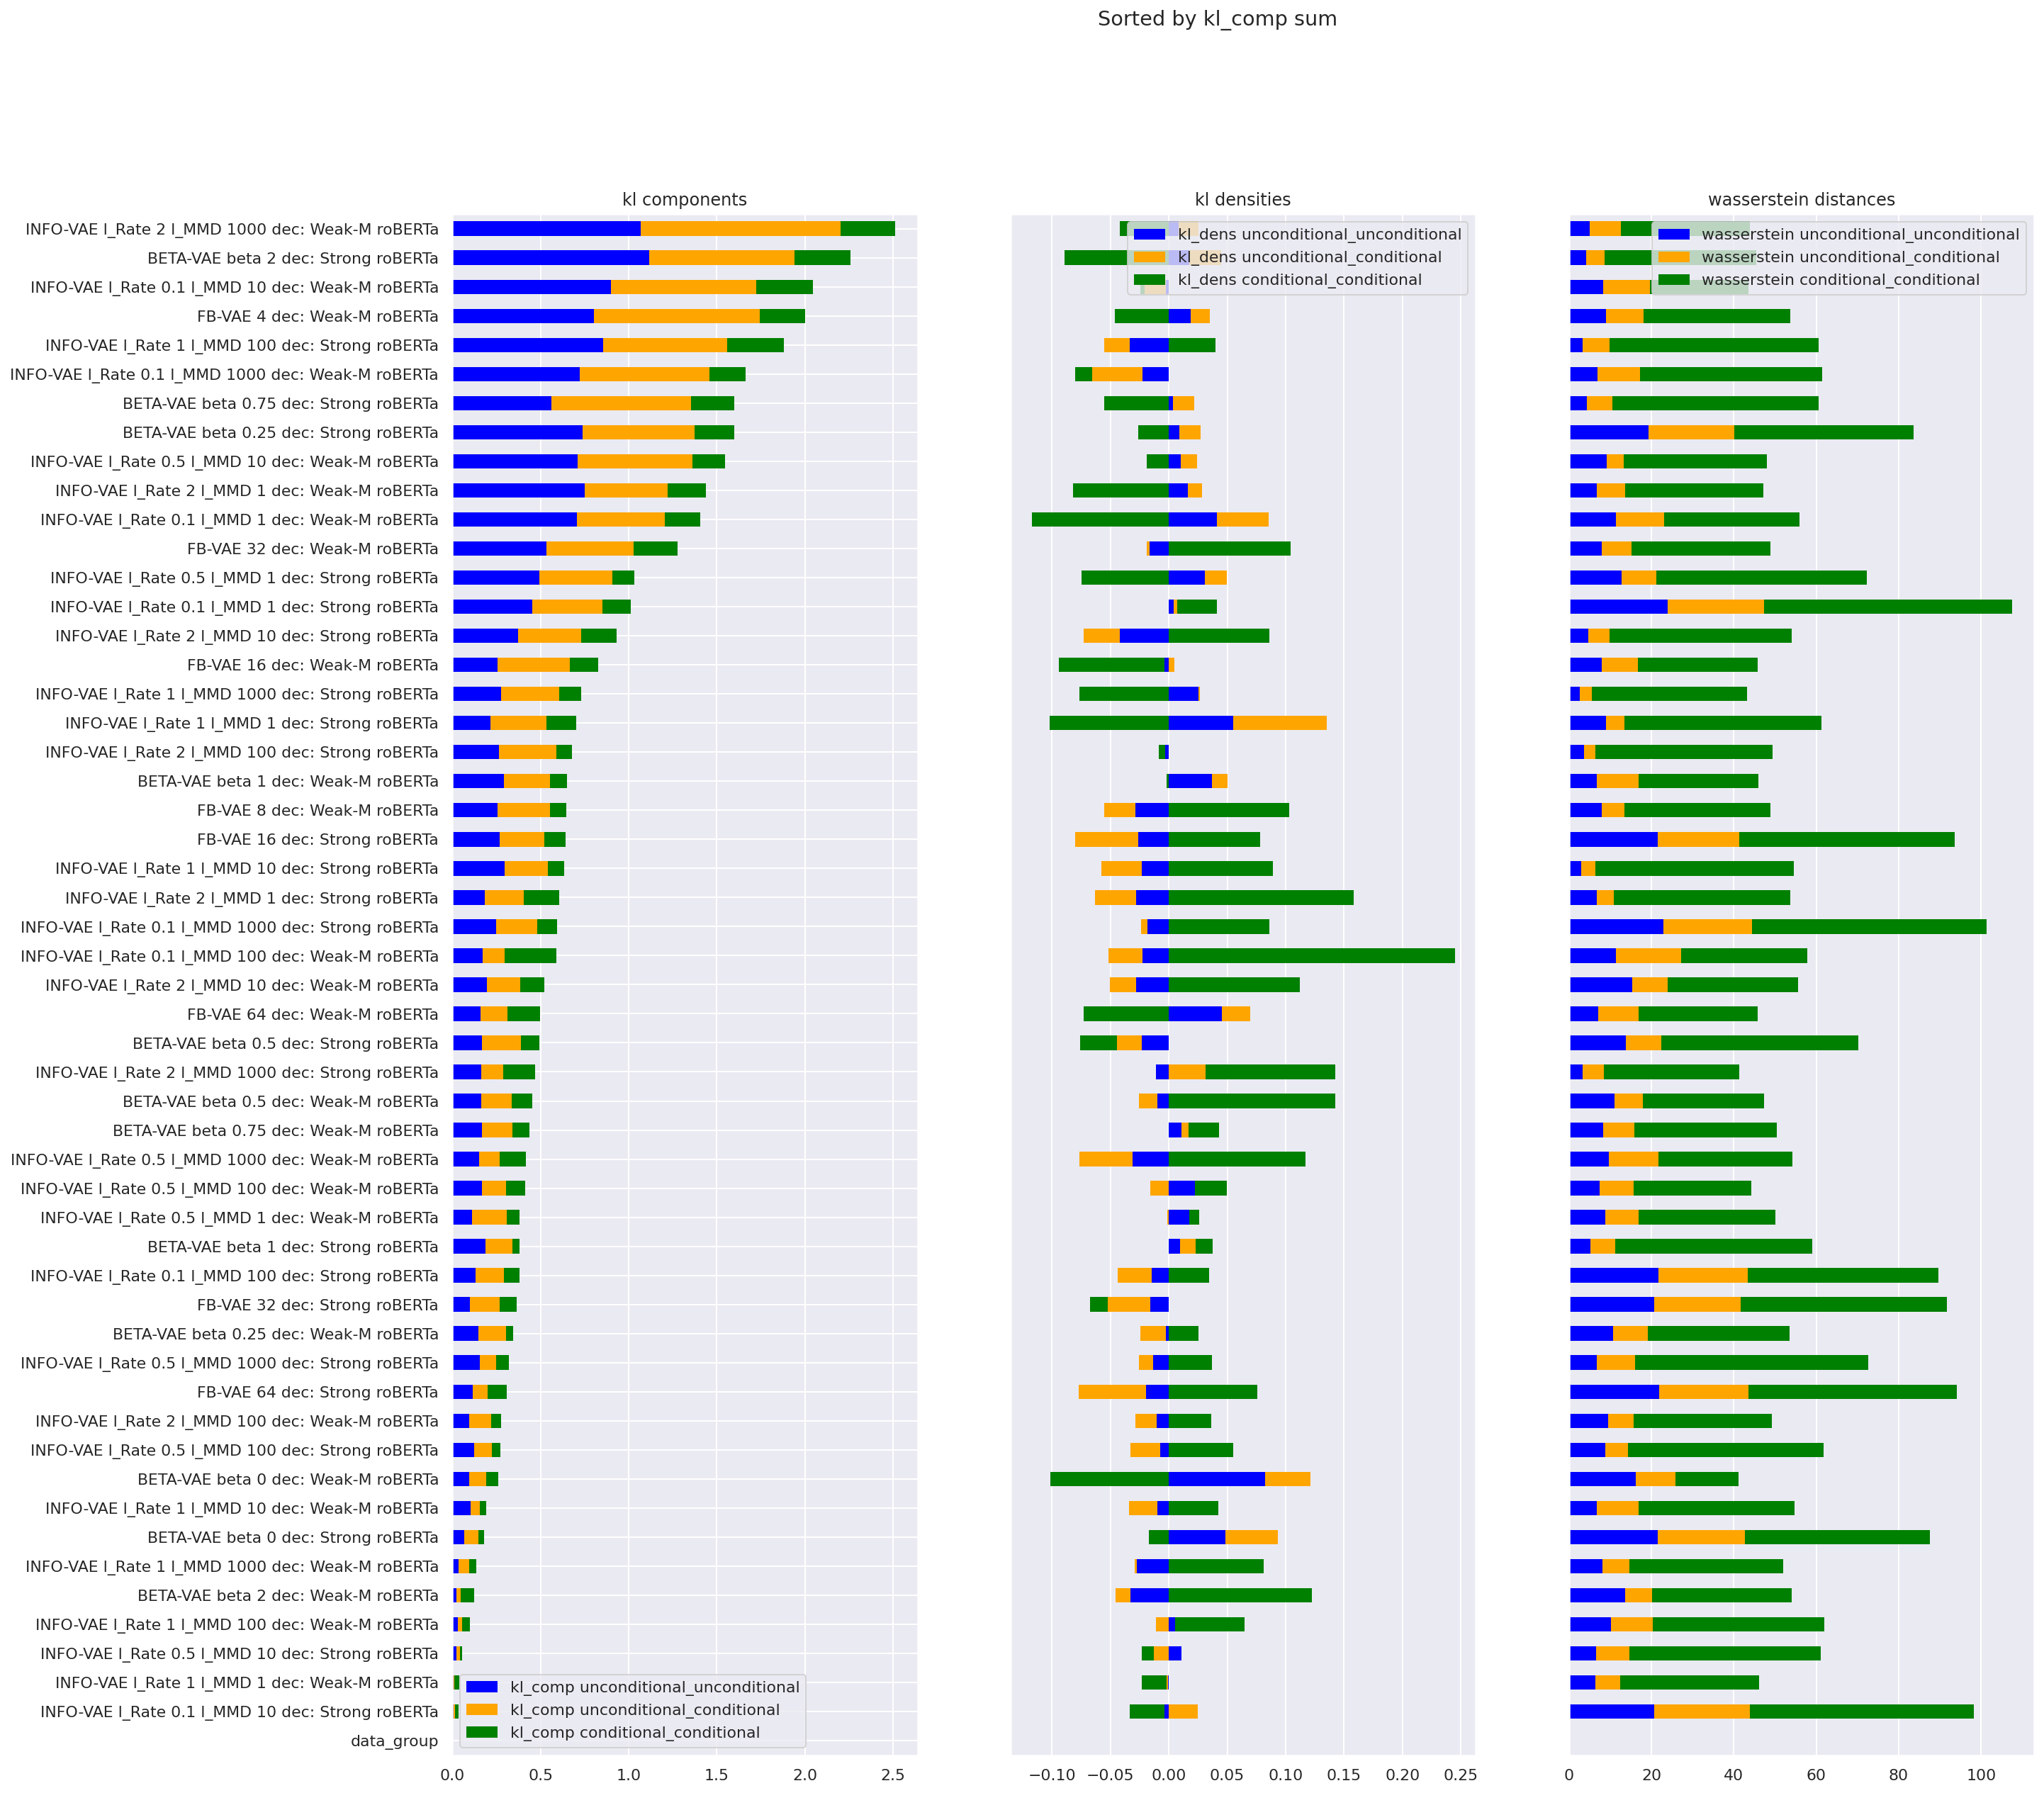

In [32]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only=None)

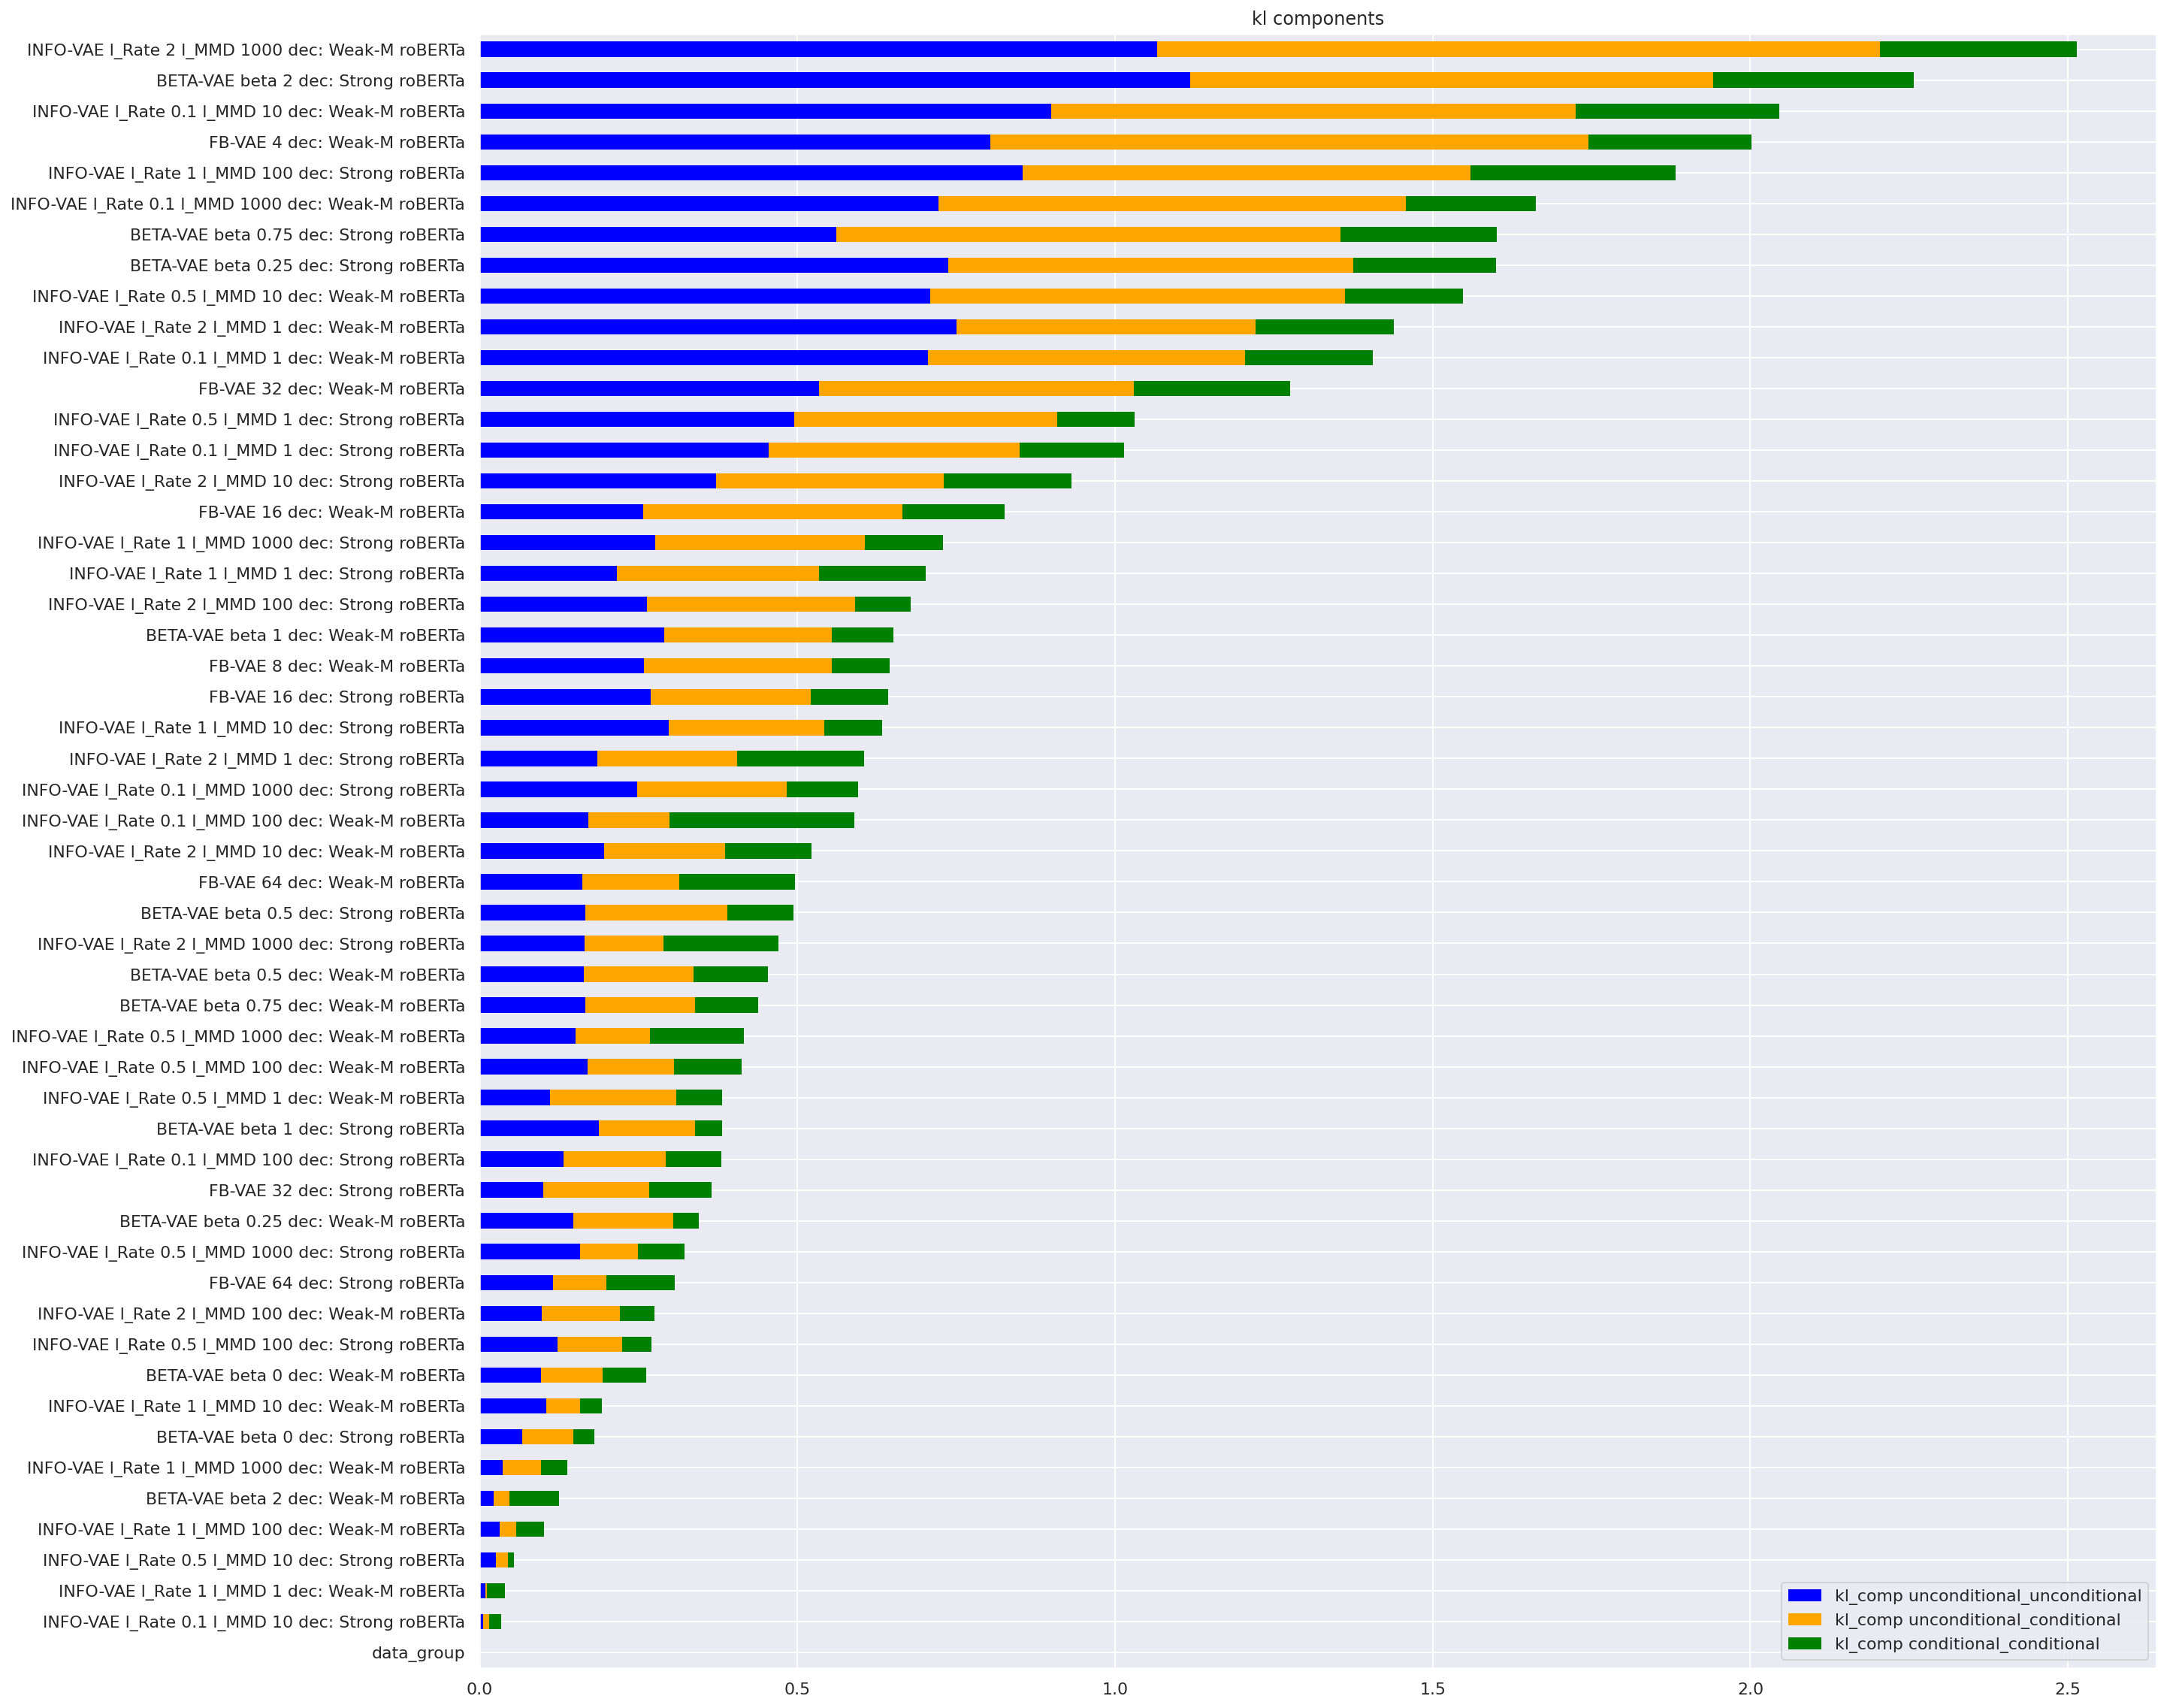

In [33]:
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp")

In [ ]:
all_df

# Old code below

In [ ]:
# CODE_DIR = "/home/cbarkhof/fall-2021"
# ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
# SAMPLE_FILE = f"generative-samples.pt"
# CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

# MAX_MODEL_SAMPLES = 2000
# MODEL_SAMPLE_DIR = "/home/cbarkhof/fall-2021/clean_analysis/model_samples"

# ptb_model_text_samples = dict()

# for i, (clean_name, row) in enumerate(overview_df.iterrows()):
#     print(i, clean_name)
    
#     save_dir = f"{ANALYSIS_DIR}/{row.run_name}"
#     conditional_sample_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
#     sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
#     res = dict()
    
#     if os.path.exists(conditional_sample_file):
#         cond_samples = torch.load(conditional_sample_file)
#         res["conditional_original_text"] = cond_samples["valid"]["original_input_text"][:MAX_MODEL_SAMPLES]
#         res["conditional_sampled_text"] = cond_samples["valid"]["condtional_sample_text"][:MAX_MODEL_SAMPLES]
    
#     if os.path.exists(sample_file):
#         samples = torch.load(sample_file)
#         res["unconditional_sampled_text"] = samples["text"][:MAX_MODEL_SAMPLES] 
    
#     os.makedirs(MODEL_SAMPLE_DIR + "/" + row.run_name, exist_ok=True)
#     torch.save(res, MODEL_SAMPLE_DIR + "/" + row.run_name + "/" + "conditional_unconditional_samples.pt")